- PostgreSQL은 커밋 로그 에 트랜잭션 상태를 보관
- clog 라고도 불리는 커밋 로그는 공유 메모리에 할당되어 트랜잭션 처리 전반에 걸쳐 사용 됨.

- PostgreSQL의 트랜잭션 상태, clog 작동 방식 및 clog 유지 관리에 대해 설명.

**Transaction Status**

- PostgreSQL은 IN_PROGRESS, COMMITTED, ABORTED 및 SUB_COMMITTED의 네 가지 트랜잭션 상태를 정의.

- 처음 세 가지 상태는 설명이 필요하지 않음.
  - 예를 들어, 트랜잭션이 진행 중인 경우 해당 상태는 IN_PROGRESS임.

- SUB_COMMITTED는 하위 트랜잭션을 위한 것.

**How Clog Performs**

- 막힘은 공유 메모리에 있는 하나 이상의 8KB 페이지로 구성 됨.
- 논리적으로 배열의 인덱스가 해당 트랜잭션 ID에 해당하고 배열의 각 항목이 해당 트랜잭션 ID의 상태를 유지하는 배열을 형성
- 그림은 막힘과 작동 방식을 보여 줌.

**How the clog operates.**

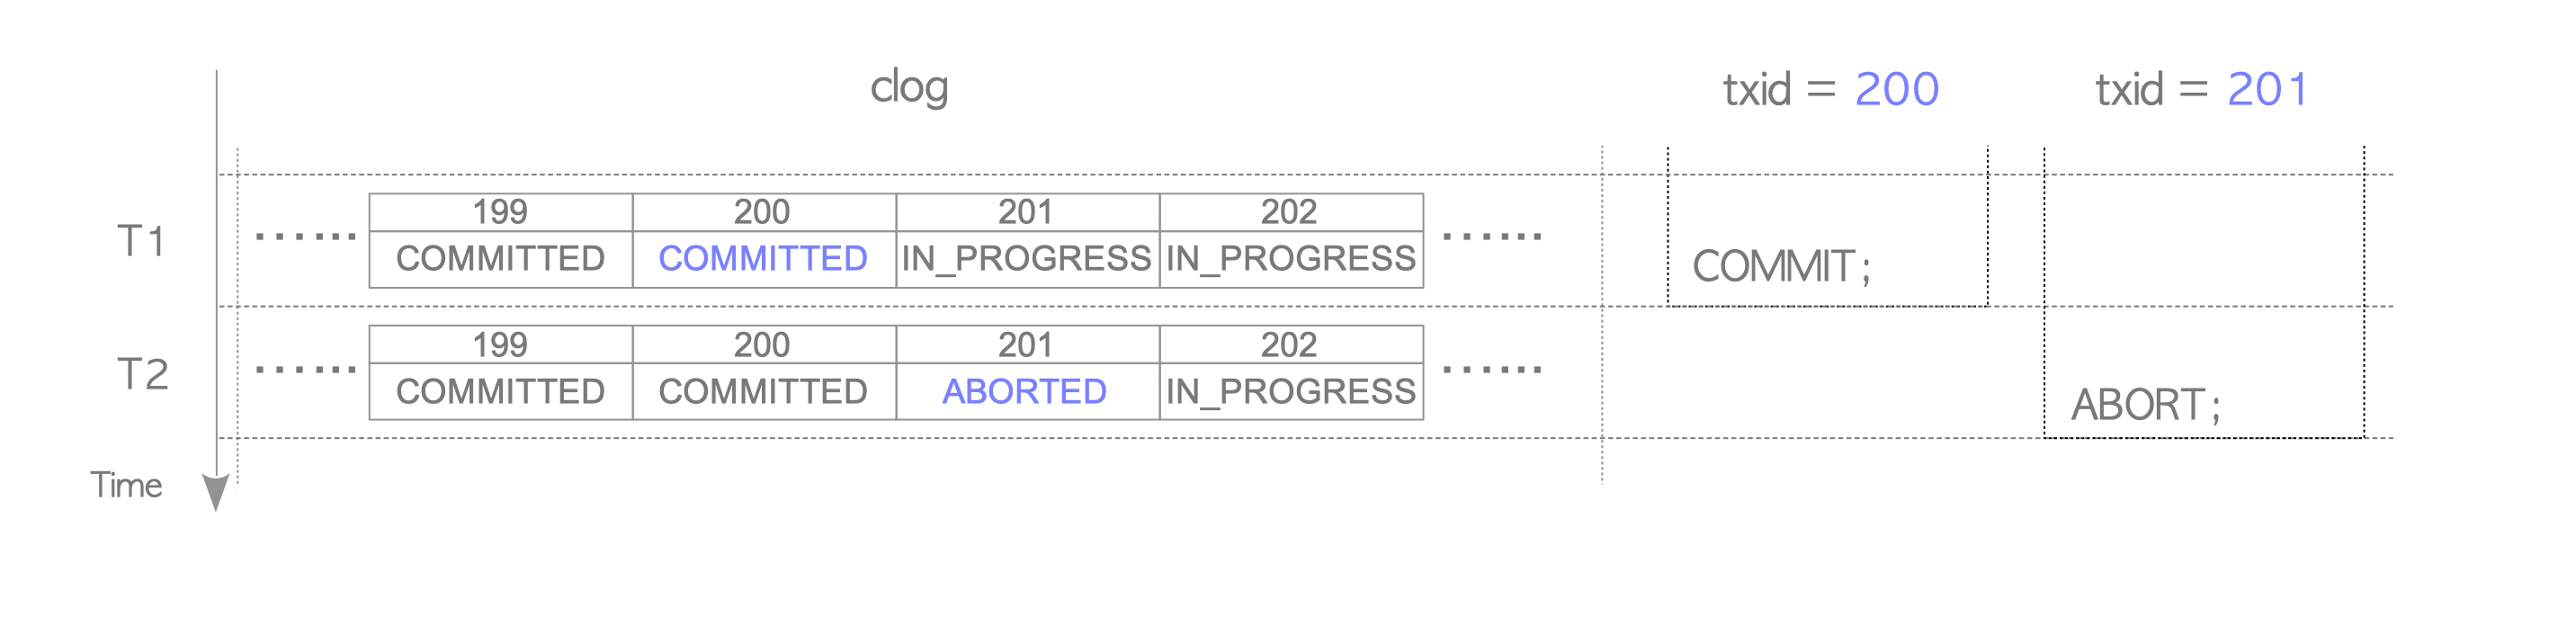

**T1:**
- txid 200 커밋; txid 200의 상태가 IN_PROGRESS에서 COMMITTED로 변경 됨.

**T2:**
- txid 201이 중단 됨. txid 201의 상태가 IN_PROGRESS에서 ABORTED로 변경 됨.

- 현재 txid가 증가하고 clog가 더 이상 이를 저장할 수 없으면 새 페이지가 추가 됨.

- 트랜잭션 상태가 필요할 때 내부 기능이 호출 됨.
- 이러한 함수는 방해물을 읽고 요청된 트랜잭션의 상태를 반환.('Hint Bits' 참조)

**Maintenance of the Clog**

- PostgreSQL이 종료되거나 체크포인트 프로세스가 실행될 때마다 방해 요소의 데이터가 pg_xact 하위 디렉터리에 저장된 파일에 기록. (pg_xact는 버전 9.6 이하에서 pg_clog 라고 불림.)
- 이 파일의 이름은 '0000', '0001' 등으로 지정.

- 최대 파일 크기는 256KB.
  - 예를 들어, 클로그가 8페이지(첫 번째 페이지부터 여덟 번째 페이지까지, 전체 크기는 64KB)를 사용하는 경우 해당 데이터는 '0000'(64KB)에 기록.
- 클로그가 37페이지(296KB)를 사용하는 경우 해당 데이터는 각각 256KB와 40KB 크기인 '0000'과 '0001'에 기록.

- PostgreSQL이 시작되면 pg_xact 파일에 저장된 데이터가 로드되어 clog를 초기화.

- 막힌 부분이 가득 찰 때마다 새로운 페이지가 추가되기 때문에 막힌 부분의 크기는 계속해서 증가.
  - 그러나 클로그의 모든 데이터가 필요한 것은 아님.

- Vacuum processing는 이러한 오래된 데이터(막힌 페이지와 파일 모두)를 정기적으로 제거.